# Predicting Solar Power Generation

## Import Libraries

In [80]:
import numpy as np  # scientific computing
import pandas as pd  # Data frames
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Assists matplotlib
import tensorflow as tf  # Neural network architectures
from tensorflow.keras import layers

#import missingno as msno  # analysing missing data
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

### Mount Drive and Import Data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [87]:
# Load dataset
url = 'https://drive.google.com/file/d/1IihIl3Nu2-wneD7dWDFdEMmpGasJCcYq/view?usp=drive_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(dwn_url)
print(df.head())

     Date-Hour(NMT)  WindSpeed  Sunshine  AirPressure  Radiation  \
0  01.01.2017-00:00        0.6         0       1003.8       -7.4   
1  01.01.2017-01:00        1.7         0       1003.5       -7.4   
2  01.01.2017-02:00        0.6         0       1003.4       -6.7   
3  01.01.2017-03:00        2.4         0       1003.3       -7.2   
4  01.01.2017-04:00        4.0         0       1003.1       -6.3   

   AirTemperature  RelativeAirHumidity  SystemProduction  
0             0.1                   97               0.0  
1            -0.2                   98               0.0  
2            -1.2                   99               0.0  
3            -1.3                   99               0.0  
4             3.6                   67               0.0  


In [88]:
# Changed index and display
df["Date-Hour(NMT)"] = df["Date-Hour(NMT)"].astype(np.datetime64)  # set the data type of the datetime column to np.datetime64
df.set_index("Date-Hour(NMT)", inplace=True)  # set the datetime columns to be the index
df.index.name = "datetime"  # change the name of the index
# show data frame
df.head()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
datetime,,,,,,,
2017-01-01 00:00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
2017-01-01 01:00:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2017-01-01 02:00:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
2017-01-01 03:00:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
2017-01-01 04:00:00,4.0,0,1003.1,-6.3,3.6,67,0.0


## Data Wrangling

In [ ]:
# check the data frame for missing values and incorrect data types
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   WindSpeed            8760 non-null   float64
 1   Sunshine             8760 non-null   int64  
 2   AirPressure          8760 non-null   float64
 3   Radiation            8760 non-null   float64
 4   AirTemperature       8760 non-null   float64
 5   RelativeAirHumidity  8760 non-null   int64  
 6   SystemProduction     8760 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 547.5 KB


**There isn't any missing value in the data frame, and the data types are okay too.**

In [ ]:
# get the statistical summary
df.describe()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2.639823,11.180479,1010.361781,97.538493,6.978893,76.719406,684.746071
std,1.628754,21.171295,12.793971,182.336029,7.604266,19.278996,1487.454665
min,0.000000,0.000000,965.900000,-9.300000,-12.400000,13.000000,0.000000
25%,1.400000,0.000000,1002.800000,-6.200000,0.500000,64.000000,0.000000
50%,2.300000,0.000000,1011.000000,-1.400000,6.400000,82.000000,0.000000
75%,3.600000,7.000000,1018.200000,115.600000,13.400000,93.000000,464.249950
max,10.900000,60.000000,1047.300000,899.700000,27.100000,100.000000,7701.000000


**More than 50% of the values of `Radiation` variable are negative where there is no energy generation. But these negative values seem to be due to mishandling of data because `Radiation` cannot have negative values (the instance where PV panels instead of sun emit radiation). So, setting these values to 0 isn't a bad option.**

In [ ]:
# replace the negative values of `Radiation` by zero
df.loc[df.Radiation.lt(0), "Radiation"] = df.Radiation[df.Radiation < 0] * 0

# get the statistical summary
df.describe()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2.639823,11.180479,1010.361781,100.594087,6.978893,76.719406,684.746071
std,1.628754,21.171295,12.793971,180.614494,7.604266,19.278996,1487.454665
min,0.000000,0.000000,965.900000,-0.000000,-12.400000,13.000000,0.000000
25%,1.400000,0.000000,1002.800000,-0.000000,0.500000,64.000000,0.000000
50%,2.300000,0.000000,1011.000000,-0.000000,6.400000,82.000000,0.000000
75%,3.600000,7.000000,1018.200000,115.600000,13.400000,93.000000,464.249950
max,10.900000,60.000000,1047.300000,899.700000,27.100000,100.000000,7701.000000


In [ ]:
# create date and time features from index that may be helpful in EDA and ML algorithms
def create_date_time_features(df):
    '''create time series features from the index '''

    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear

    return df

# perform feature engineering on datetime index, and show the data frame
df = create_date_time_features(df)
df.head()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,hour,day_of_year
datetime,,,,,,,,,
2017-01-01 00:00:00,0.6,0,1003.8,-0.0,0.1,97,0.0,0,1
2017-01-01 01:00:00,1.7,0,1003.5,-0.0,-0.2,98,0.0,1,1
2017-01-01 02:00:00,0.6,0,1003.4,-0.0,-1.2,99,0.0,2,1
2017-01-01 03:00:00,2.4,0,1003.3,-0.0,-1.3,99,0.0,3,1
2017-01-01 04:00:00,4.0,0,1003.1,-0.0,3.6,67,0.0,4,1


## Exploratory Data Analysis

### Correlation between Features

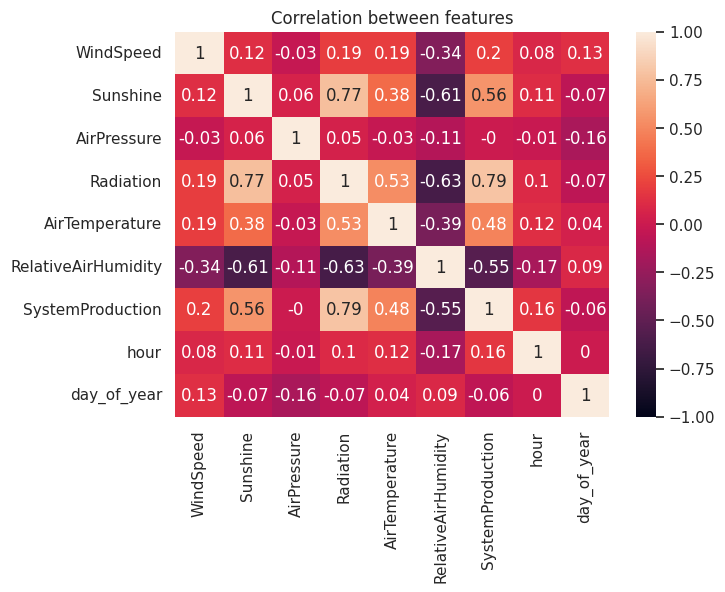

In [ ]:
# correlation between features
sns.set()
_, ax = plt.subplots(figsize=(7, 5))

# plot the heatmap of correlations
fig = sns.heatmap(df.corr().round(2), annot=True, vmin=-1, vmax=1, ax=ax);

# set the title
fig.set_title("Correlation between features");

**A few important points can be inferred from above:**
*  Radiation, Sunshine, RelativeAirHumidity, AirTemperature are be correlated which isn't surprising. It also indicates that there is multicollinearity in the dataset.
*  Radiation along with Sunshine shows positive correlation with SystemProduction which is an obvious discovery. Rest of the features don't seem to be correlated to SystemProduction. Further analysis will be performed to reach the conclusion.

**Important note when using models (that use gradient descent to optimize parameters) on this dataset:** One might consider that multicolliearity might give the mentioned algorithms a hard time and might affect their interpretability but that is not the case.
According to statistical approaches, the problem only arises when these multicollinearity reaches above `0.9`.

### Pairwise Relationships in the Dataset

In [ ]:
# plot pairwise relationships of the dataset
sns.set()  # set the seaborn's theme as default
g = sns.pairplot(df);

# set the title
g.fig.suptitle("Pairwise Relations between Features", y=1.03);

Output hidden; open in https://colab.research.google.com to view.

**The independent varible `SystemProduction` is highly skewed which might indicates that we might have more time of the year when there is less production of energy.**

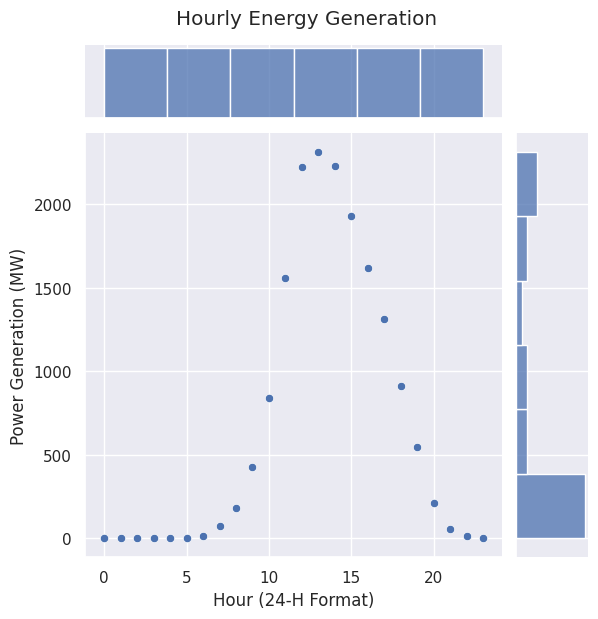

In [ ]:
# check the effect of `hour` and `day_of_year` on the `SystemProduction`
sns.set()
g = sns.jointplot(data=df[["hour", "SystemProduction"]].groupby("hour").mean(), x="hour", y="SystemProduction")
g.set_axis_labels(xlabel=("Hour (24-H Format)"), # set x-label
                  ylabel=("Power Generation (MW)"))  # set y-label
g.fig.suptitle("Hourly Energy Generation", y=1.03);  # set the title

Paired with our previous assumption and the dataset's summary, we can say that the high skewness in the `SystemProduction`'s distribution is due to fact that there is mostly low energy generation and no generation at night hours when there is no sun.

The plot also shows that during peak hours, we would have higher average energy generation.

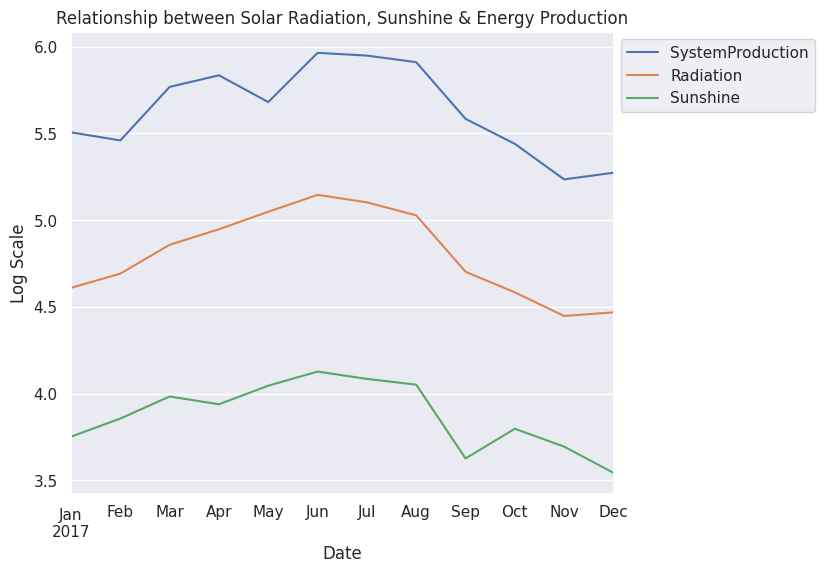

In [ ]:
# check the relationship between `Radiation` and `SystemProduction`
sns.set()
tmp_df = df[["SystemProduction", "Radiation", "Sunshine"]].resample("1M").sum()
tmp_df = tmp_df.agg(np.log10)

# plot the line graph
tmp_df.plot(figsize=(7, 6), xlabel="Date", ylabel="Log Scale");

# set the title
plt.title("Relationship between Solar Radiation, Sunshine & Energy Production");

# set the legend to outside the grid
plt.legend(bbox_to_anchor=(1, 1));

***Warning: This plot is only for demonstration purposes for non-technical audiences which indicates that there is a positive relationship between the `Radiation`, `Sunshine` and `SystemProduction` throughout the year as seen from the previosly plotted heatmap.***

**Warning:** For exploratory data analysis, we need to drop the records (hours) in which there is no generation of any energy `SystemProduction < 1 MW`. It is due to the fact that the hours at which the Sunshine and Radiation are zero will have no SystemProduction and thus creating useless data points for exploratory data analysis. We could also use Sunshine and Radiation as a mask to filter out the records but sticking to a systematic approach might be more useful when there is a potential noise in those features (like at night hours, there won't be any Sunshine and Radiation).

In [ ]:
# get the `hours` where there is less than 1 MW production
list_ = []
for k, v in (df.groupby("hour").SystemProduction.mean() < 1).to_dict().items():
    if v == True:  # where values are less than 1MW
        list_.append(k)

# save the filtered data frame for EDA as `eda_df`
eda_df = df[~df.hour.isin(list_)]

### Solar Energy Generation (Monthly & Quarterly)

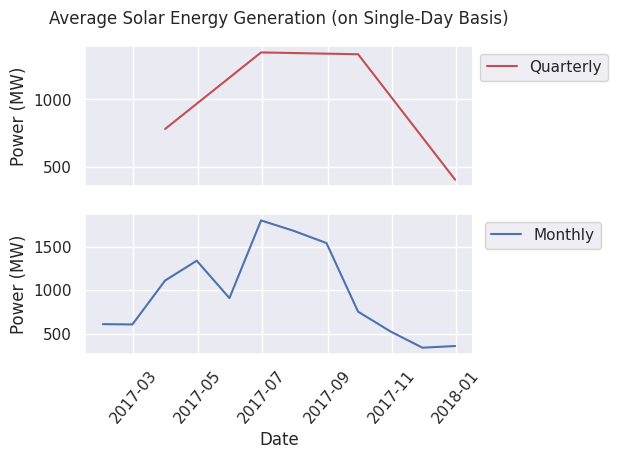

In [ ]:
# plot monthly solar generation
sns.set_context("notebook")
fig , [ax1, ax2] = plt.subplots(2, 1, figsize=(5, 4), sharex=True); # get the subplots

Q = eda_df.SystemProduction.resample("1Q").mean()
M = eda_df.SystemProduction.resample("1M").mean()

sns.lineplot(x=Q.index, y=Q.values, color="r", ax=ax1, label="Quarterly")
sns.lineplot(x=M.index, y=M.values, color="b", ax=ax2, label='Monthly')

# set the title and labels
ax1.set_title("Average Solar Energy Generation (on Single-Day Basis)", y=1.1);
ax1.legend(bbox_to_anchor=(1, 1));  # set the legend to be outside the grid
ax2.legend(bbox_to_anchor=(1.35, 1));  # set the legend to be outside the grid
plt.xticks(rotation=50);
ax1.set_ylabel("Power (MW)");
ax2.set_ylabel("Power (MW)");
plt.xlabel("Date");  # set the shaped

It can be easily inferred that in spring and summer, the production of the energy increases quite significantly when compared to other seasons.

### Effect of Wind Speed on Power Generation

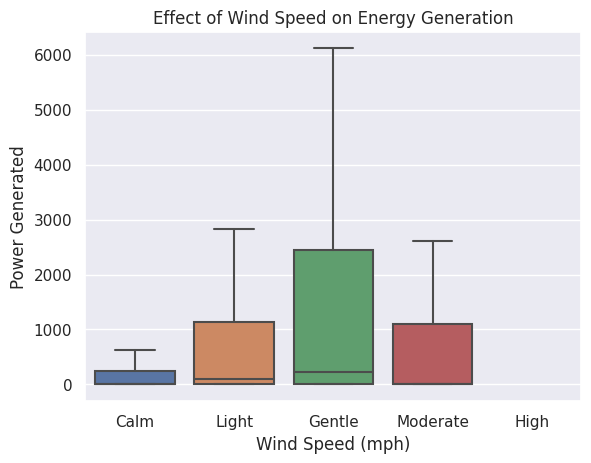

In [ ]:
# plot the power generation with respect to wind speed
sns.set()
tmp_df = eda_df[["WindSpeed", "SystemProduction"]]  # create a temporary data frame
tmp_df.loc[:, "WindSpeed"] = pd.cut(tmp_df.WindSpeed,
                                    bins=[-np.inf, 1, 4, 7, 12, np.inf],  # set bins for a total of 5 labels
                                    labels=['Calm', 'Light', 'Gentle', 'Moderate', 'High']) # set the labels names

sns.boxplot(data=tmp_df,
            x="WindSpeed",
            y="SystemProduction",
            sym="");  # remove the outliers

# set the labels and title
plt.title("Effect of Wind Speed on Energy Generation");
plt.xlabel("Wind Speed (mph)");
plt.ylabel("Power Generated");

***Warning: This plot is to be used only for non-technical audiences (and shouldn't be used for inference by technical staff).***

The relationship doesn't seem to be linear but it is to some extent positive. According to the [article](https://ae-solar.com/wind-effect-on-solar-panels/#:~:text=Wind%20speed%20has%20little%20influence,can%20increase%20just%20PV%20efficiency.), which states, *Wind speed has little influence on solar radiation, which is directly proportional to the atmospheric temperature while it is inversely proportional to the relative humidity. Consequently, the wind does not increase solar irradiance effectively. In other words, appropriate wind can increase just PV efficiency.*, we can say that things are normal on our side. As for the other parts discussed here, they will be analysed further in the later sections.

### Effect of Air Temperature on Power Generation

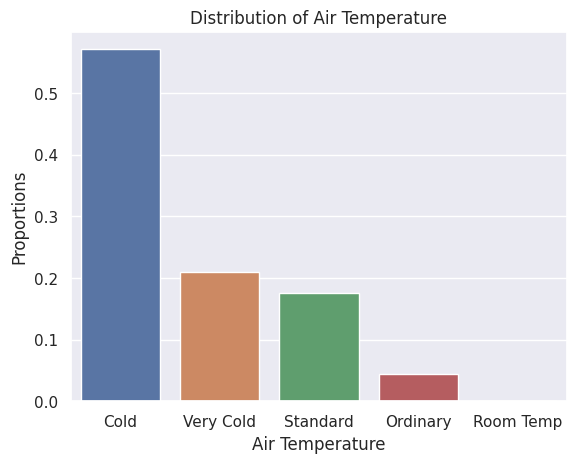

In [ ]:
# check the proportions of the AirTemperature categories
tmp_df.loc[:, "AirTemperature"] = pd.cut(eda_df.AirTemperature,
                                         bins=[-np.inf, 0, 15, 20, 25, 30, np.inf], # get the bins for a total of 6 labels
                                         labels=['Very Cold', 'Cold', 'Standard', 'Ordinary', 'Room Temp', 'Moderate'])\
                                    .cat.remove_unused_categories() # remove the empty categories

sns.set()  # set the seaborn theme to default
sns.barplot(data=tmp_df.AirTemperature.value_counts(normalize=True).to_frame().T)  # plotting a barplot

# set the labels and title
plt.xlabel("Air Temperature")
plt.ylabel("Proportions")
plt.title("Distribution of Air Temperature");

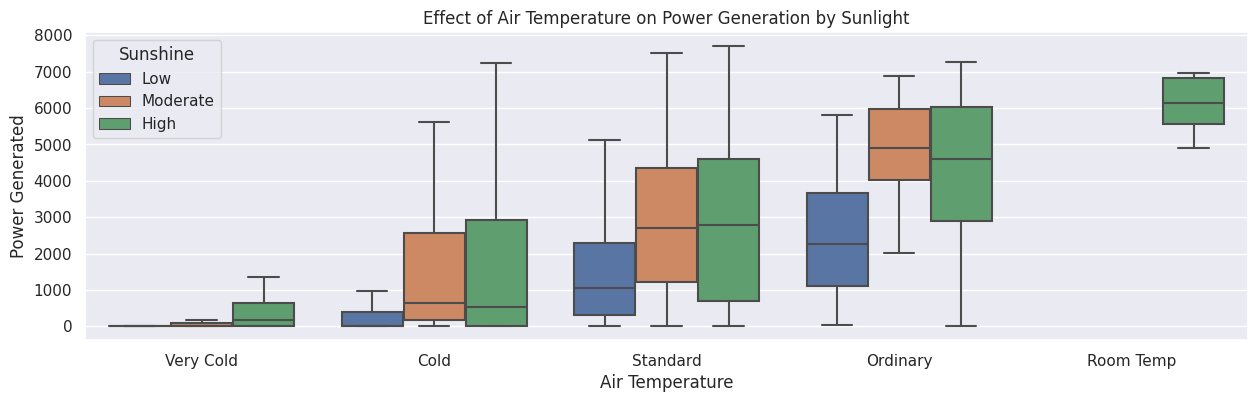

In [ ]:
# Effect of Air Temperature on Power Generation by Sunlight
sns.set()
tmp_df.loc[:, "Sunshine"] = pd.cut(eda_df.Sunshine, bins=3,  # make 3 bins of the data for 3 labels
                                   labels=["Low", "Moderate", "High"]).cat.remove_unused_categories()

plt.subplots(figsize=(15, 4))  # set the figure dimensions
sns.boxplot(data=tmp_df, x="AirTemperature", hue="Sunshine", y="SystemProduction", sym="")  # plot a boxplot with no outliers

# set the labels and title
plt.xlabel("Air Temperature")
plt.ylabel("Power Generated")
plt.title("Effect of Air Temperature on Power Generation by Sunlight");

***Warning: This plot is to be used only for non-technical audiences (and shouldn't be used for inference by technical staff).***

The Air Temperature might just tell us about the season, and Sunlight both seem to have positive interactive effect on the power generation. But it's important to note that the during low air temperatures which makes up a major part of the year, the mean average generation is low during winter and autumn seasons.

### Effect of Air Pressure on Power Generation

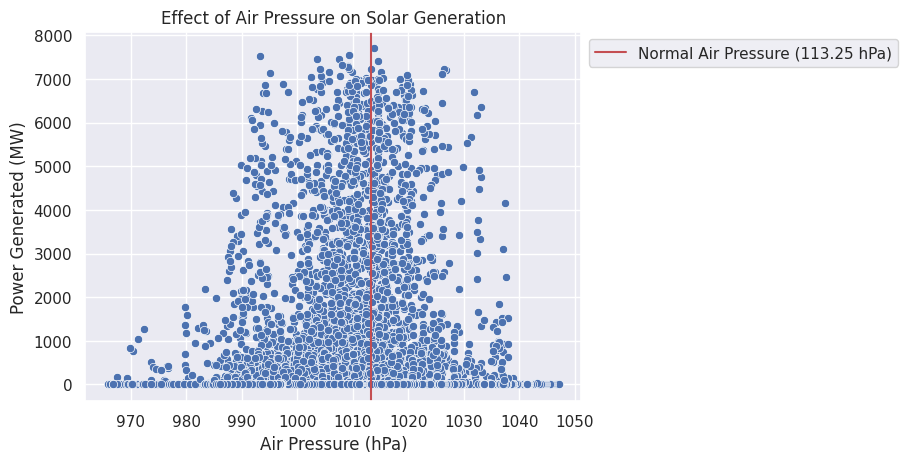

In [ ]:
# plot system production by air pressure
normal_pressure = 1013.25 # the unit is in `hPa`
sns.scatterplot(data=eda_df, x="AirPressure", y="SystemProduction")
plt.axvline(normal_pressure, color="r", label="Normal Air Pressure (113.25 hPa)")
plt.xlabel("Air Pressure (hPa)")
plt.ylabel("Power Generated (MW)")
plt.title("Effect of Air Pressure on Solar Generation")
plt.legend(bbox_to_anchor=(1, 1));

Photo Voltaic Panels seems to be working effectively on normal air pressure. But it is also important to note the interactive effect of Air Pressure and Radiation on power generation before drawing any solid conclusion. Otherwise, we won't have an unbiased estimate.

### Effect of Relative Air Humidity on Power Generation

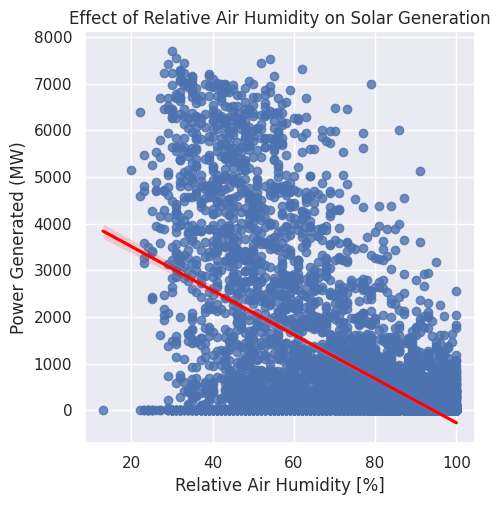

In [ ]:
# plot system production by air pressure
sns.lmplot(data=eda_df, x="RelativeAirHumidity", y="SystemProduction", line_kws={"color": "red"})

# set the labels and title
plt.xlabel("Relative Air Humidity [%]")
plt.ylabel("Power Generated (MW)")
plt.title("Effect of Relative Air Humidity on Solar Generation");

Relative Air Humidity has a negative relationship with Solar Generation.

## Build ML Model for Predicting Solar Power Generation

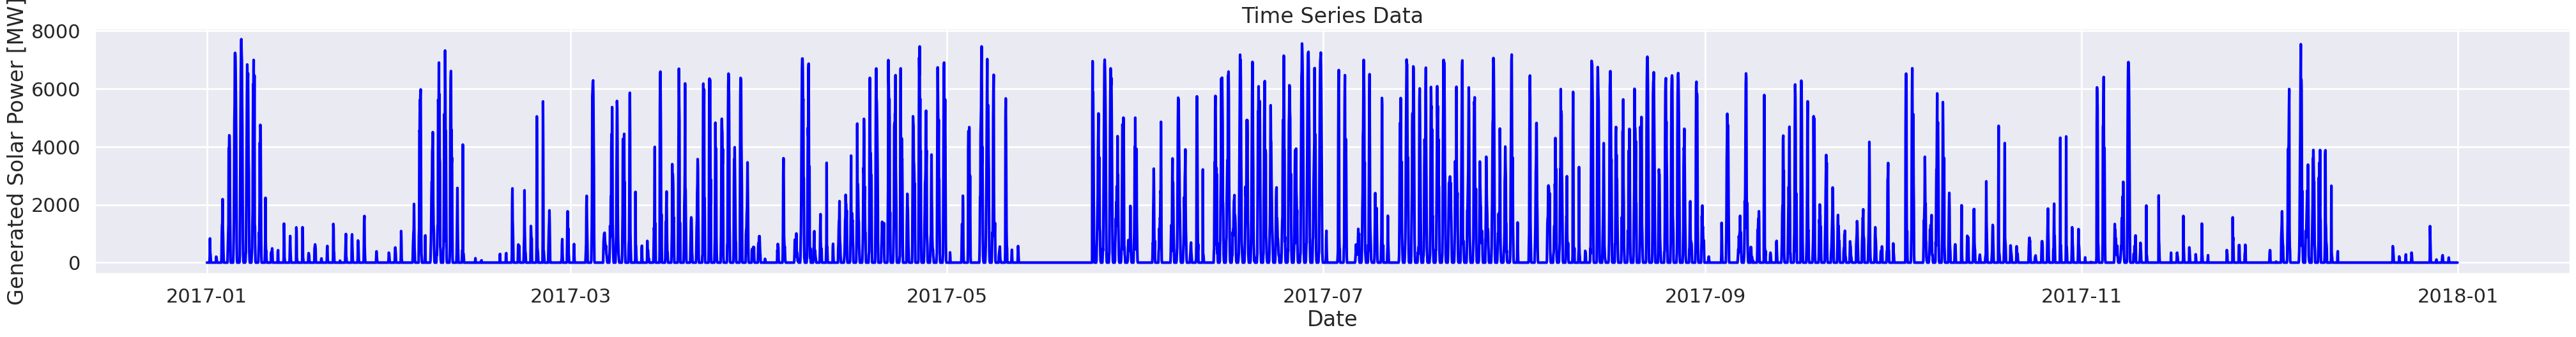

In [ ]:
# Plot time series data
sns.set_context("poster")
plt.subplots(figsize=(50, 5)) # set the figure dimensions
sns.lineplot(x=df.index, y=df.SystemProduction.values, color="blue")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Generated Solar Power [MW]")
plt.title("Time Series Data");

### Splitting and Preparing the Training and Validation Datasets

Model will predict solar energy generation for the next hour *(1 Horizon)* by taking previous 24 hours *(24 Windows)* as its inputs along with the other features.

In [ ]:
# let's shift the data
def prepare_data(df):
    '''Splits the dataset into (features (pre-defined), windows, horizon).'''

    to_split = df.copy(deep=True) # get a copy of `df`
    forecast = to_split.SystemProduction  # get the y-values
    to_split = to_split.shift(1)  # shift the features for current hours to next hour for forcasting
    to_split.rename({"SystemProduction": "SP_t_1"}, axis=1, inplace=True)  # rename the column for consistency
    to_split["forecast"] = forecast  #  put the forecast back into the data frame that is to be splitted

    windows = 24  # number of windows

    # perform windowing
    for n in range(2, windows+1, 1):
        to_split[f"SP_t_{n}"] = to_split.forecast.shift(n)
    to_split.dropna(inplace=True)

    # split the windows from `to-split` to `windows_df`
    window_cols = []
    windows_df = pd.DataFrame([], index=to_split.index)
    for col in to_split.columns:
        if "SP" in col: # where the windows names are matched
            windows_df[f"{col}"] = to_split[f"{col}"]
            to_split.drop(col, axis=1, inplace=True)

    # get the features and horizon from `to_split` and save them
    columns = to_split.columns.values.tolist()
    other_feats, horizon = to_split[[cols for cols in columns if cols != "forecast"]], to_split["forecast"]

    return other_feats, windows_df, horizon

# get the three types of data
other_feats, windows, horizon = prepare_data(df)

# check the shapes of the data
other_feats.shape, windows.shape, horizon.shape

((8736, 8), (8736, 24), (8736,))

# **Feature Scaling**

In [ ]:
# Initialize the MinMaxScaler and transform the features to get the data on the same scale for smooth convergence
other_feats_mms = other_feats.copy()
other_feats_mms.loc[:, :] = MinMaxScaler().fit_transform(other_feats)

# get `other_feats_mms` statistical summary
other_feats_mms.describe()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,hour,day_of_year
count,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000,8736.000000
mean,0.242283,0.186353,0.546371,0.112062,0.491005,0.732627,0.500000,0.501259
std,0.149453,0.352876,0.157324,0.200954,0.192606,0.221566,0.300982,0.288691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.128440,0.000000,0.452088,0.000000,0.326582,0.586207,0.250000,0.250000
50%,0.211009,0.000000,0.554054,0.000000,0.478481,0.793103,0.500000,0.500000
75%,0.330275,0.116667,0.643735,0.128821,0.653165,0.919540,0.750000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's split this data as: 9 months for training and 3 months for validation.
There's an issue with the last 4 months of the data. As there's only winter's data and model will not be trained on it due to the lack of data for any other year. But this effect can be neutralized by not using the model to forcast deep into the future.

In [ ]:
def prepare_dataset(other_feats, windows, horizon, cutoff_datetime="2017-10-31 23:00:00", only_splits=False):
    '''Splits into train-validation datasets and prepares those datasets into `tf.data.Dataset` format for efficient training and validation.'''

    # create a mask for splitting the data into train and validation datasets
    mask = (windows.index < cutoff_datetime)

    # get the other_feats splits
    X_train_other_feats, X_test_other_feats = other_feats[mask].to_numpy(), other_feats[~mask].to_numpy()

    # get the windows splits
    X_train_windows, X_test_windows = windows[mask].to_numpy(), windows[~mask].to_numpy()

    # get the horizon splits
    y_train_horizon, y_test_horizon = horizon[mask], horizon[~mask]

    # if only_splits==True the return only the splits without preparing the datasets for training
    if only_splits:
        return ((X_train_other_feats, X_test_other_feats), (X_train_windows, X_test_windows), (y_train_horizon, y_test_horizon))

    # else continue
    else:
        # expand the dimensions of horizon to (None, 1) and perform splits
        y_train_horizon, y_test_horizon = np.expand_dims(horizon[mask].to_numpy(), axis=1), np.expand_dims(horizon[~mask].to_numpy(), axis=1)

        # get the data into `tf.data.Dataset` format and create a data pipeline
        X_train = tf.data.Dataset.from_tensor_slices((X_train_windows, X_train_other_feats)) # get the inputs of our model ready
        y_train = tf.data.Dataset.from_tensor_slices(y_train_horizon) # outputs of the model
        train_dataset = tf.data.Dataset.zip((X_train, y_train)) # create the dataset
        train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE).cache()  # if we were using models like ARIMA then shuffling the dataset would've have been beyond toxic

        # perform the same operation but for testing data
        X_test = tf.data.Dataset.from_tensor_slices((X_test_windows, X_test_other_feats)) # get the inputs of our model ready
        y_test = tf.data.Dataset.from_tensor_slices(y_test_horizon) # outputs of the model
        test_dataset = tf.data.Dataset.zip((X_test, y_test)) # create the dataset
        test_dataset = test_dataset.batch(128).prefetch(tf.data.AUTOTUNE).cache() # this was an uneccessary step btw

        return train_dataset, test_dataset

In [ ]:
# Get train and test datasets
train_dataset, test_dataset = prepare_dataset(other_feats, windows, horizon)
#train_dataset, test_dataset

In [ ]:
# get only the train and test splits of horizon for visualization
_, _, (train_horizon, test_horizon) = prepare_dataset(other_feats, windows, horizon, only_splits=True)

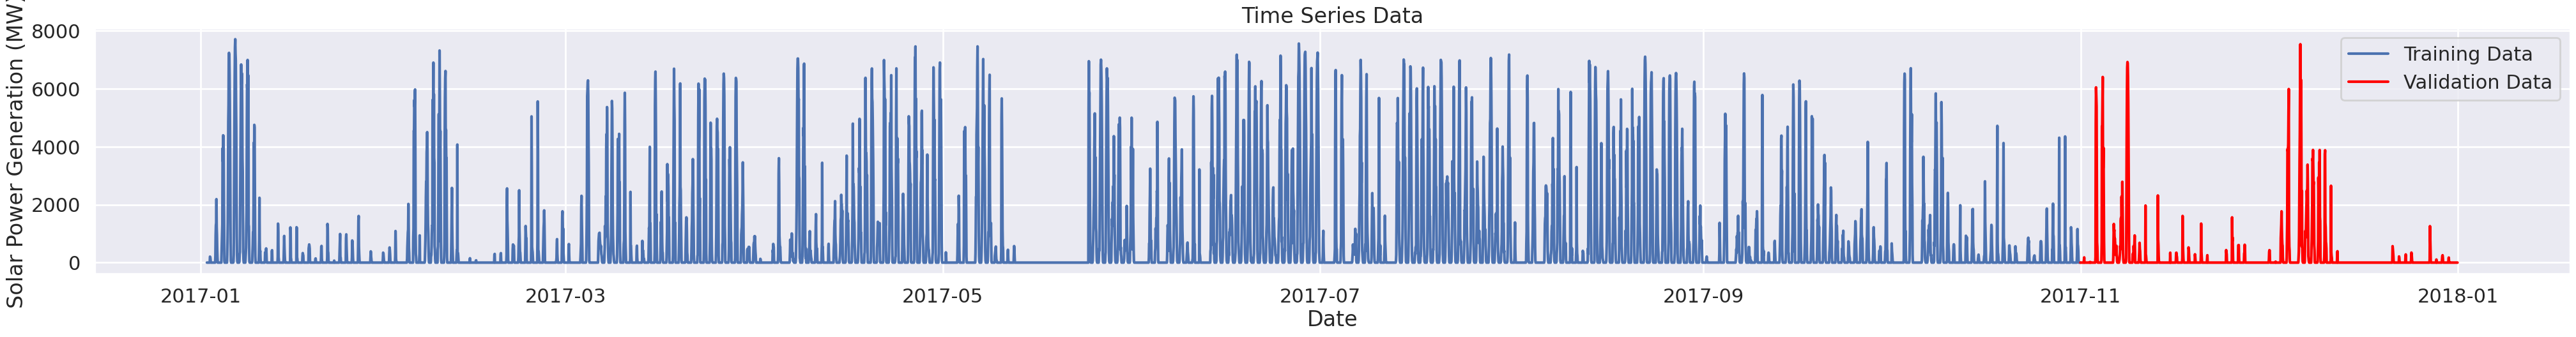

In [ ]:
# Plot train and test datasets
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(50, 5))
sns.lineplot(x=train_horizon.index,y=train_horizon.values, label="Training Data", color="b", ax=ax)
sns.lineplot(x=test_horizon.index, y=test_horizon.values, color="red", label="Validation Data", ax=ax)

# set the axis labels and title
plt.xlabel("Date")
plt.ylabel("Solar Power Generation (MW)")
plt.title("Time Series Data");

### Model Building

Two parts of the model:

1. Foirst part of the model, implements architecture based on N-BEATS algorithm (Refer: Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) (https://arxiv.org/pdf/1905.10437.pdf).

2. Since the features other than windows that are `Radiation`, `RelativeAirHumidity` etc play a huge role in Solar Generation. So, for the second part, we will need fully connected layers that will take pervious days features `other_feats_df` and concatenate its feature vector with the  feature vector of the first part of the model to forecast the solar generation.

#### Architecture - I

In [ ]:
# parameters for n-beats block
N_EPOCHS = 200 #5000  # number of training cycles that will be formed on the whole dataset
N_NEURONS = 256 #512  # for hidden layers of n-beats block
N_LAYERS = 4  # number of hidden layers for n-beats block
N_STACKS = 2 #30  # total number of stacks of n-beats block
WINDOW_SIZE = 24  # our windows size
HORIZON = 1  # one horizon (forecast one hour into the future)

INPUT_SIZE = WINDOW_SIZE * HORIZON  # input size used to get the backcast
THETA_SIZE = INPUT_SIZE + HORIZON  # output of the n-beats block from which the backcast and forecast are extracted

# chectk the shapes
INPUT_SIZE, THETA_SIZE

(24, 25)

In [ ]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs): # the call method is what runs when the layer is called
        x = inputs
        for layer in self.hidden: # pass inputs through each hidden layer
            x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

        return backcast, forecast

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # create a network of stacks with len(N_STACKS-1) as first stack was initialized earlier

    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"4Layer_Block_{i}" #name=f"NBeatsBlock_{i}"
    )(residuals) # pass it in residuals (the backcast)

    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# build n-beats model that will be merged with another smaller model
model_1 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_1_N-BEATS")

# check model summary
model_1.summary()

Model: "model_1_N-BEATS"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 stack_input (InputLayer)    [(None, 24)]                 0         []                            
                                                                                                  
 InitialBlock (NBeatsBlock)  ((None, 24),                 210201    ['stack_input[0][0]']         
                              (None, 1))                                                          
                                                                                                  
 subtract_00 (Subtract)      (None, 24)                   0         ['stack_input[0][0]',         
                                                                     'InitialBlock[0][0]']        
                                                                                    

#### Architecture - II

In [ ]:
# build the second model
model_2 = tf.keras.Sequential([
    layers.Input(shape=(8,), name="input_2"),
    layers.Dense(16),
    layers.LeakyReLU(), # choose leaky-relu empirically
    layers.Dense(8),
    layers.LeakyReLU(),  # choose leaky-relu empirically
    layers.Dense(8),
])

# check model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 16)                144       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 8)                 136       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8)                 0         
                                                                 
 dense_22 (Dense)            (None, 8)                 72        
                                                                 
Total params: 352 (1.38 KB)
Trainable params: 352 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Combining both Architectures

In [ ]:
# building the final model by combining `model_1` and `model_2`
output = layers.Concatenate()([model_1.output, model_2.output])
output = layers.Dense(1)(output)
output = layers.LeakyReLU()(output)  # ReLU activation wasn't used because it might be detrimental to model training during gradient descent
model = tf.keras.Model(inputs=[model_1.input, model_2.input], outputs=output)  # two inputs from two previous models and a single output that will be our forecast

# check model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 stack_input (InputLayer)    [(None, 24)]                 0         []                            
                                                                                                  
 dense_20 (Dense)            (None, 16)                   144       ['input_2[0][0]']             
                                                                                                  
 InitialBlock (NBeatsBlock)  ((None, 24),                 210201    ['stack_input[0][0]']         
                              (None, 1))                                                    

#### Visualizing the Model Architecture

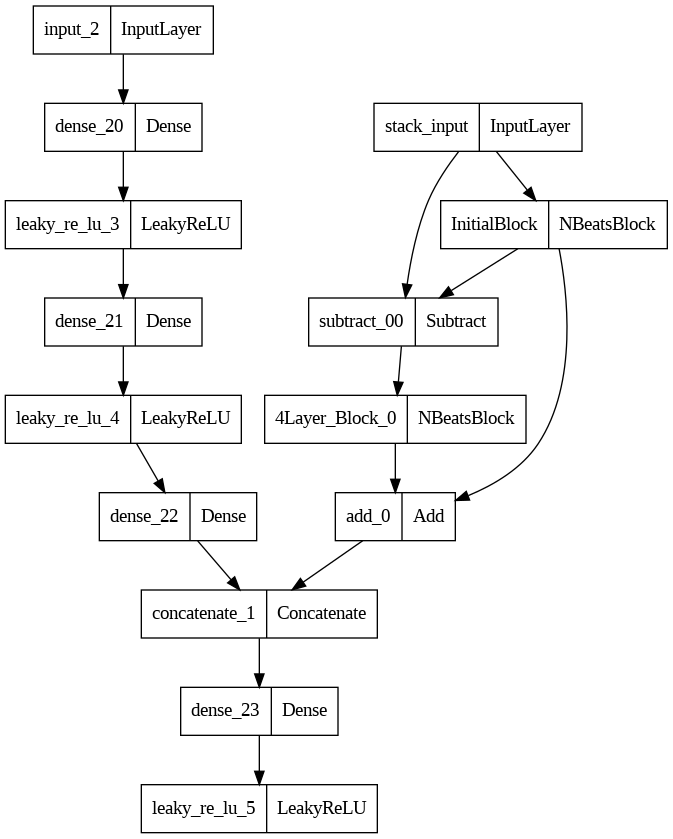

In [ ]:
# plot the model
tf.keras.utils.plot_model(model)

#### Training the Model Architecture

In [ ]:
# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
history = model.fit(train_dataset,
          epochs=N_EPOCHS,
          validation_data=test_dataset,
          verbose=1, # (optional) set it to `0` to prevent large amounts of training outputs
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True),  # setting-up check points for reducing the learning rate and early stopping if val-loss isn't improved
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=80, verbose=1)])

Epoch 1/200
57/57 [==============================] - 5s 10ms/step - loss: 335.5615 - mse: 550777.6875 - val_loss: 122.8092 - val_mse: 160893.7031 - lr: 0.0010
Epoch 2/200
57/57 [==============================] - 0s 7ms/step - loss: 280.0730 - mse: 414294.0938 - val_loss: 124.7483 - val_mse: 183028.2344 - lr: 0.0010
Epoch 3/200
57/57 [==============================] - 0s 8ms/step - loss: 281.9611 - mse: 422653.6562 - val_loss: 122.0341 - val_mse: 183487.0312 - lr: 0.0010
Epoch 4/200
57/57 [==============================] - 0s 7ms/step - loss: 284.6696 - mse: 431145.4375 - val_loss: 116.1642 - val_mse: 151165.0469 - lr: 0.0010
Epoch 5/200
57/57 [==============================] - 0s 7ms/step - loss: 278.6140 - mse: 405780.9688 - val_loss: 108.6148 - val_mse: 140238.3750 - lr: 0.0010
Epoch 6/200
57/57 [==============================] - 0s 7ms/step - loss: 256.2851 - mse: 359608.3750 - val_loss: 116.6682 - val_mse: 156702.7500 - lr: 0.0010
Epoch 7/200
57/57 [==============================] 

#### Results

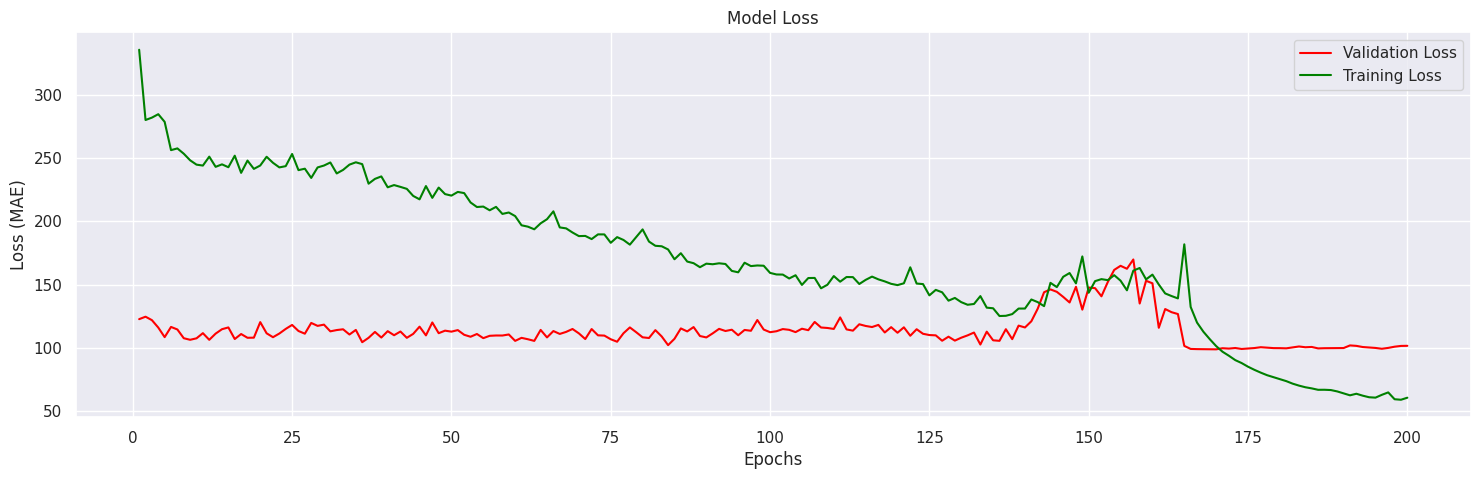

In [ ]:
# get the training and validation loss by epochs
history_ = history.history
sns.set()
plt.subplots(figsize=(18, 5)) # set the figure dimensions
sns.lineplot(x=range(1, len(history_["val_loss"])+1), y=history_["val_loss"],color="red", label="Validation Loss")
sns.lineplot(x=range(1, len(history_["loss"])+1), y=history_["loss"], color="green", label="Training Loss")

# get the axis labels and title
plt.title("Model Loss")
plt.ylabel("Loss (MAE)")
plt.xlabel("Epochs");

In [ ]:
# get the model predictions and create a data frame for visualization and get mean-absolute-error
preds = model.predict(test_dataset) # get the predictions
p_df = pd.DataFrame(preds, index=test_horizon.index) # create the data frame
p_df[p_df.values <= 0] = 0  # set values to zero where solar generation is negative

# get the mean_absolute error again
print(f"MAE :{mae(p_df.values, test_horizon.values)}")

12/12 [==============================] - 0s 2ms/step
MAE :101.20617184618163


**Plot the ground-truth and forecast and compare them with residuals to get a better sense of how the model is forecasting.**

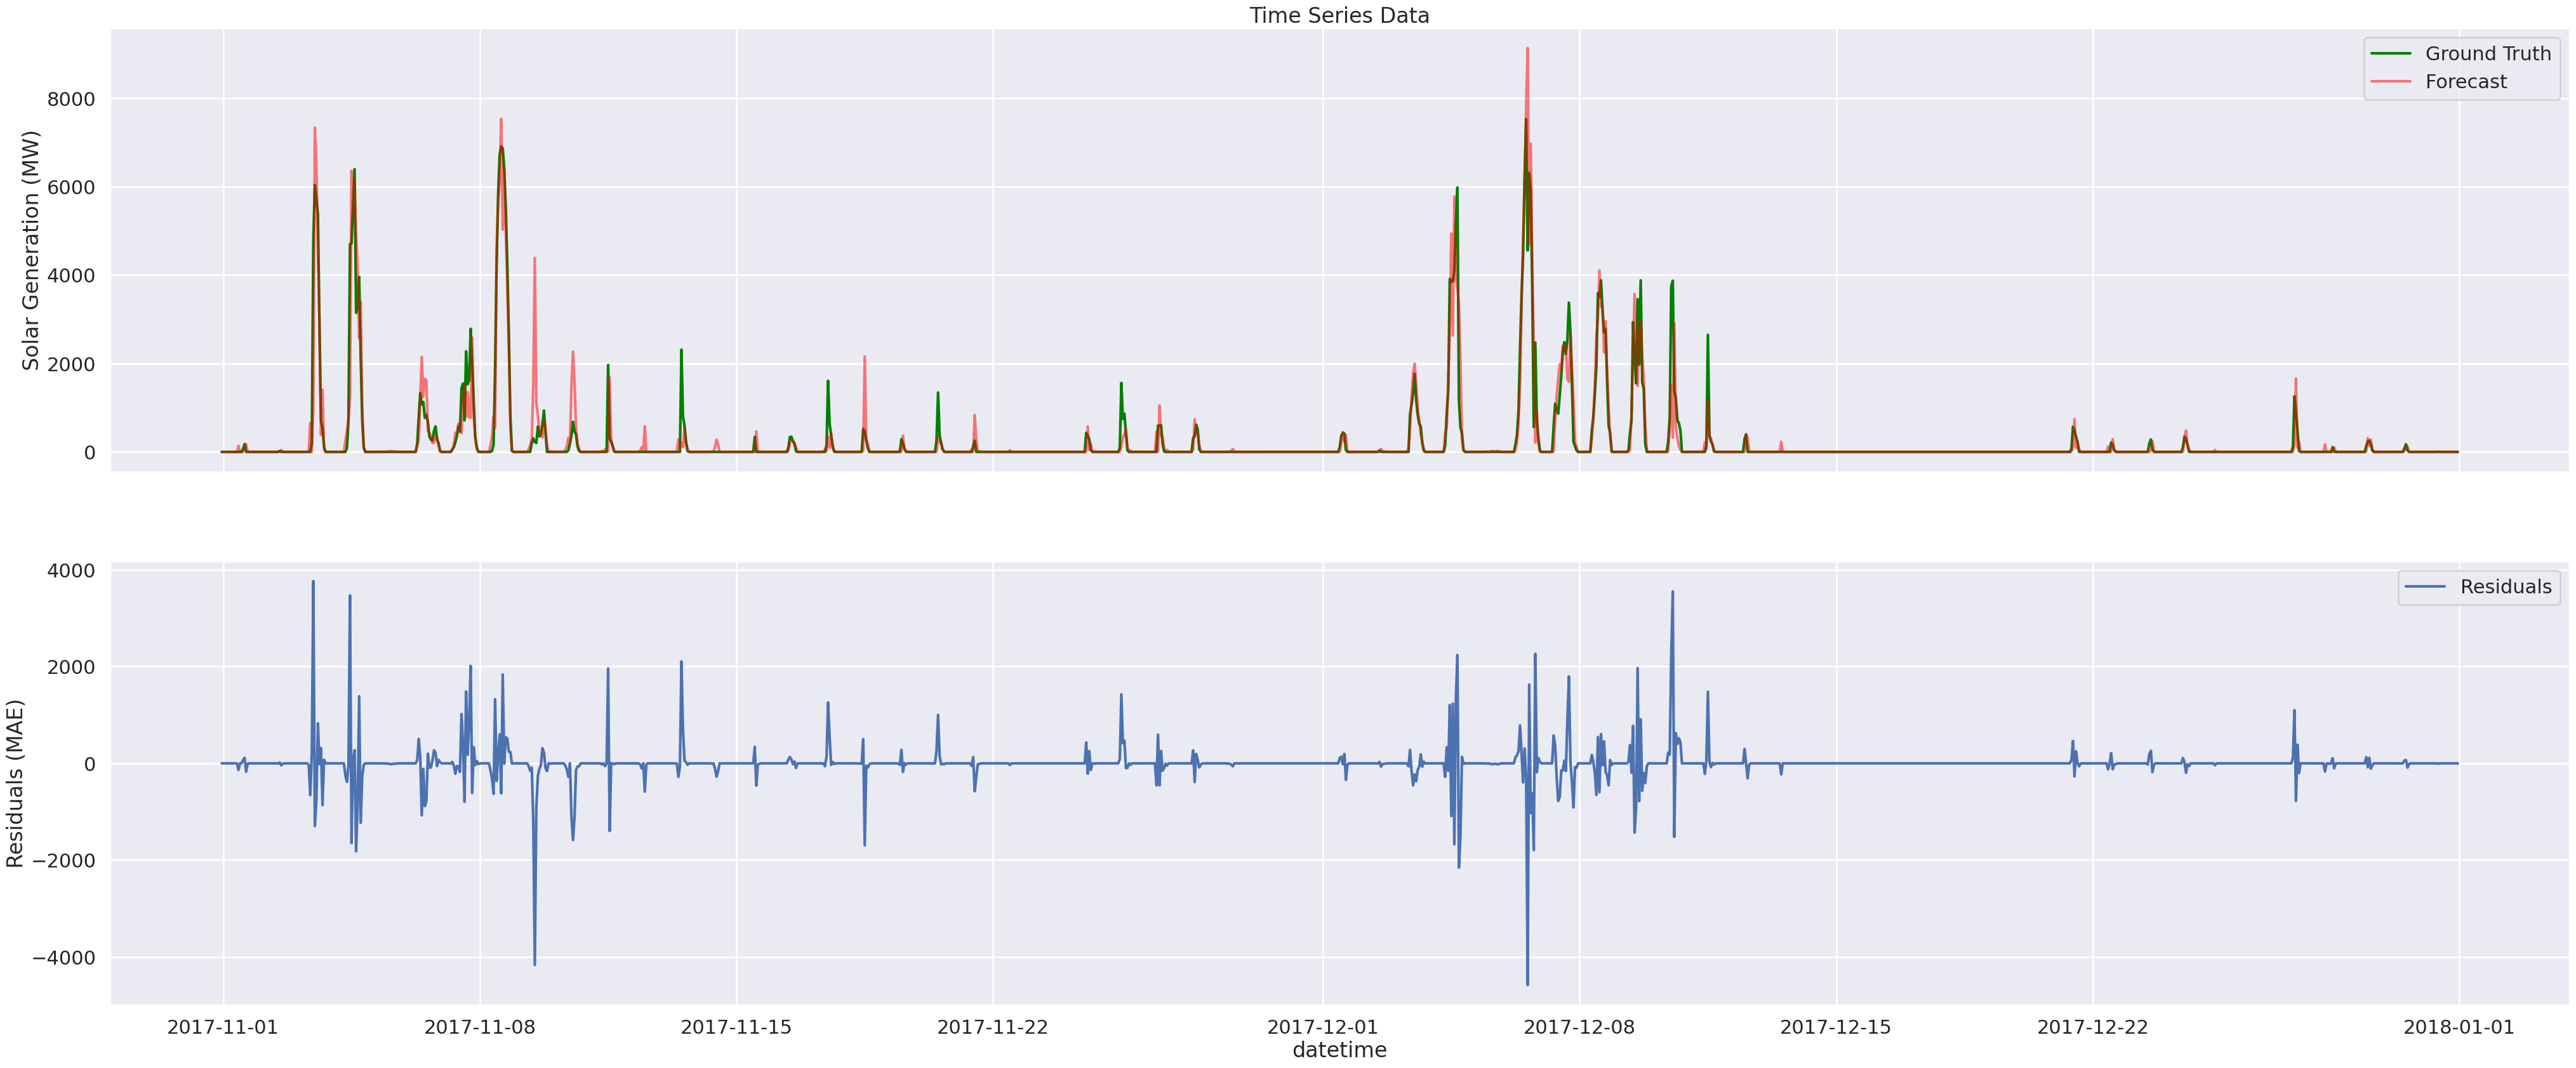

In [ ]:
# plot the ground-truth and forecast and compare them with residuals
sns.set_context("poster")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 20), sharex=True) # get the figure dimensions for the two figures and plot on the same x-axis
sns.lineplot(x=test_horizon.index, y=test_horizon.values, color="green", ax=ax1, label="Ground Truth") # get the ground-truth validation data
sns.lineplot(x=p_df.index.values, y=p_df.values.flatten(), color="red", dashes=True, ax=ax1, label="Forecast", alpha=0.5)  # get the forecast
# set the axis labels and title
ax1.set_xlabel("Date")
ax1.set_ylabel("Solar Generation (MW)")
ax1.set_title("Time Series Data");

# plot the residuals
residuals = (test_horizon.values - p_df.values.flatten())
sns.lineplot(y=residuals, x=test_horizon.index, ax=ax2, label="Residuals")
ax2.set_ylabel("Residuals (MAE)"); # set the y-label for residuals